In [2]:
import lightning.pytorch as pl
from lightning.pytorch.loggers import TensorBoardLogger
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
# import dataset, network to train and metric to optimize
from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer, QuantileLoss, GroupNormalizer
from lightning.pytorch.tuner import Tuner
import torch
from pytorch_forecasting.metrics import MAE,MAPE, MASE
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
import torch
print(torch.cuda.is_available())  # Should return True
print(torch.cuda.get_device_name(0))  # Should print your GPU name

True
NVIDIA GeForce RTX 2050


In [6]:
# Import the dataset
crypto_prices_exogenous = pd.read_csv('./crypto_prices_exogenous.csv')

In [8]:
crypto_prices_exogenous.head()

,Date,BTC_Price,BTC_Market_Cap,ETH_Price,ETH_Market_Cap,XRP_Price,XRP_Market_Cap,Gold_Price,IGREA,interest_rate,NASDAQ_Price,SP_500_Price,us_10_year_bond_yield,us_dollar_index,usdt_Price,vix_value
0,2015-08-15,261.495,3.845289e+09,1.69244,1.028299e+08,0.008426,2.681497e+08,1114.11,-38.011264,0.14,5048.23,2091.5,2.201,96.853,1.0,12.83
1,2015-08-16,258.514,3.769613e+09,1.51268,8.315809e+07,0.008313,2.667222e+08,1114.11,-38.011264,0.14,5048.23,2091.5,2.201,96.853,1.0,12.83
2,2015-08-17,257.953,3.749087e+09,1.20073,8.493465e+07,0.008303,2.648410e+08,1117.66,-38.011264,0.15,5091.70,2102.4,2.170,97.135,1.0,13.02
3,2015-08-18,213.158,3.694728e+09,1.09508,8.813926e+07,0.007708,2.609860e+08,1118.01,-38.011264,0.15,5059.35,2096.9,2.192,97.388,1.0,13.79
4,2015-08-19,226.722,3.601004e+09,1.25117,9.728590e+07,0.007773,2.498591e+08,1134.46,-38.011264,0.15,5019.05,2079.6,2.129,96.687,1.0,15.25


In [10]:
crypto_prices_exogenous = crypto_prices_exogenous.drop(columns=['ETH_Price', 'ETH_Price', 'ETH_Market_Cap', 'XRP_Price', 'XRP_Market_Cap'], axis=1)

## Feature Engineering

In [13]:
# Add volatility features
crypto_prices_exogenous['BTC_Volatility'] = crypto_prices_exogenous['BTC_Price'].pct_change().rolling(window=7).std()

In [15]:
# Add momentum indicators
crypto_prices_exogenous['BTC_7day_momentum'] = crypto_prices_exogenous['BTC_Price'].pct_change(periods=7)
crypto_prices_exogenous['BTC_14day_momentum'] = crypto_prices_exogenous['BTC_Price'].pct_change(periods=14)
crypto_prices_exogenous['BTC_30day_momentum'] = crypto_prices_exogenous['BTC_Price'].pct_change(periods=30)

In [17]:
# Add Relative Strength Index (RSI)
def calculate_rsi(series, period=14):
    delta = series.diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    
    avg_gain = gain.rolling(window=period).mean()
    avg_loss = loss.rolling(window=period).mean()
    
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

crypto_prices_exogenous['RSI_14'] = calculate_rsi(crypto_prices_exogenous['BTC_Price'], 14)

In [19]:
# Fill NaN values created by rolling calculations
crypto_prices_exogenous.fillna(method='bfill', inplace=True)

C:\Users\Sathmika\AppData\Local\Temp\ipykernel_24328\273316341.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  crypto_prices_exogenous.fillna(method='bfill', inplace=True)


In [21]:
crypto_prices_exogenous.head()

,Date,BTC_Price,BTC_Market_Cap,Gold_Price,IGREA,interest_rate,NASDAQ_Price,SP_500_Price,us_10_year_bond_yield,us_dollar_index,usdt_Price,vix_value,BTC_Volatility,BTC_7day_momentum,BTC_14day_momentum,BTC_30day_momentum,RSI_14
0,2015-08-15,261.495,3.845289e+09,1114.11,-38.011264,0.14,5048.23,2091.5,2.201,96.853,1.0,12.83,0.075739,-0.118591,-0.12123,-0.117933,37.195653
1,2015-08-16,258.514,3.769613e+09,1114.11,-38.011264,0.14,5048.23,2091.5,2.201,96.853,1.0,12.83,0.075739,-0.118591,-0.12123,-0.117933,37.195653
2,2015-08-17,257.953,3.749087e+09,1117.66,-38.011264,0.15,5091.70,2102.4,2.170,97.135,1.0,13.02,0.075739,-0.118591,-0.12123,-0.117933,37.195653
3,2015-08-18,213.158,3.694728e+09,1118.01,-38.011264,0.15,5059.35,2096.9,2.192,97.388,1.0,13.79,0.075739,-0.118591,-0.12123,-0.117933,37.195653
4,2015-08-19,226.722,3.601004e+09,1134.46,-38.011264,0.15,5019.05,2079.6,2.129,96.687,1.0,15.25,0.075739,-0.118591,-0.12123,-0.117933,37.195653


## Correlation Analysis

BTC_Price                1.000000
BTC_Market_Cap           0.999078
NASDAQ_Price             0.926757
SP_500_Price             0.918068
Gold_Price               0.830559
IGREA                    0.651282
interest_rate            0.366282
us_10_year_bond_yield    0.317144
us_dollar_index          0.208463
vix_value                0.043082
usdt_Price               0.018830
BTC_Volatility           0.002141
BTC_30day_momentum      -0.002362
BTC_7day_momentum       -0.008511
BTC_14day_momentum      -0.008742
RSI_14                  -0.045899
Name: BTC_Price, dtype: float64


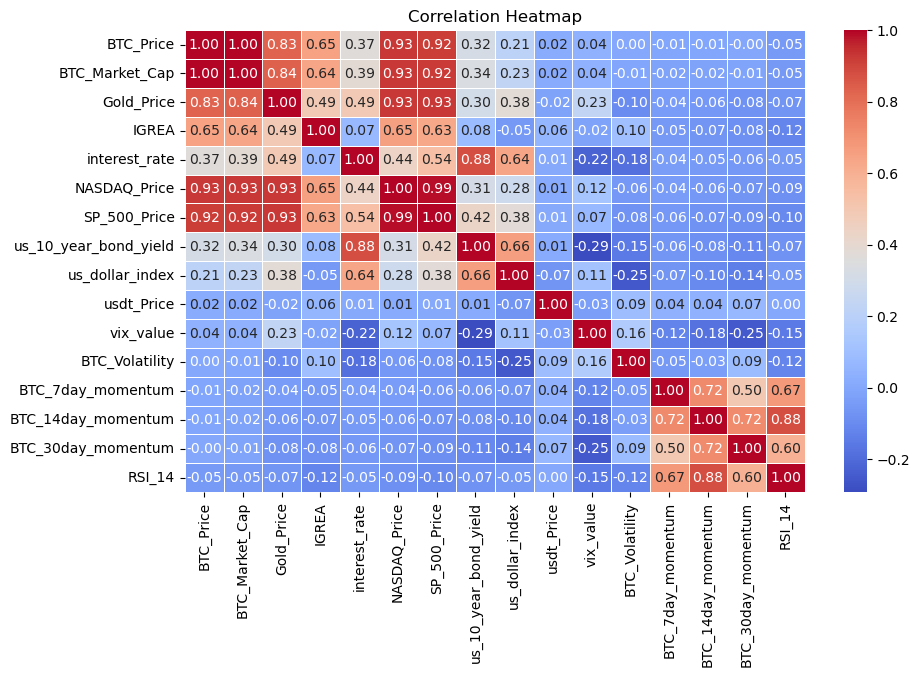

In [24]:
# Select only numeric columns for correlation analysis
df_numeric = crypto_prices_exogenous.select_dtypes(include=['number'])

# Compute the correlation matrix
corr_matrix = df_numeric.corr()

# Extract correlation values for BTC_Price
btc_correlation = corr_matrix["BTC_Price"].sort_values(ascending=False)

# Display correlation values
print(btc_correlation)

# Visualizing the correlation matrix as a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

In [26]:
# drop unwanted features
crypto_prices_exogenous.drop(columns=['us_10_year_bond_yield', 'us_dollar_index', 'vix_value', 'usdt_Price'], inplace=True)

In [28]:
crypto_prices_exogenous.head()

,Date,BTC_Price,BTC_Market_Cap,Gold_Price,IGREA,interest_rate,NASDAQ_Price,SP_500_Price,BTC_Volatility,BTC_7day_momentum,BTC_14day_momentum,BTC_30day_momentum,RSI_14
0,2015-08-15,261.495,3.845289e+09,1114.11,-38.011264,0.14,5048.23,2091.5,0.075739,-0.118591,-0.12123,-0.117933,37.195653
1,2015-08-16,258.514,3.769613e+09,1114.11,-38.011264,0.14,5048.23,2091.5,0.075739,-0.118591,-0.12123,-0.117933,37.195653
2,2015-08-17,257.953,3.749087e+09,1117.66,-38.011264,0.15,5091.70,2102.4,0.075739,-0.118591,-0.12123,-0.117933,37.195653
3,2015-08-18,213.158,3.694728e+09,1118.01,-38.011264,0.15,5059.35,2096.9,0.075739,-0.118591,-0.12123,-0.117933,37.195653
4,2015-08-19,226.722,3.601004e+09,1134.46,-38.011264,0.15,5019.05,2079.6,0.075739,-0.118591,-0.12123,-0.117933,37.195653


## scale the dataset

In [ ]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Select numerical columns (excluding 'BTC_Price' since GroupNormalizer is used)
num_features = ["BTC_Price", "BTC_Market_Cap", "Gold_Price", "NASDAQ_Price", "SP_500_Price", "IGREA", "interest_rate", "BTC_Volatility", "BTC_7day_momentum", "BTC_14day_momentum", "BTC_30day_momentum", "RSI_14"]

# Apply MinMaxScaler (default range [0, 1])
scaler = MinMaxScaler(feature_range=(0, 1))
crypto_prices_exogenous[num_features] = scaler.fit_transform(crypto_prices_exogenous[num_features])

In [33]:
# Save scaler for future use
import pickle

# Save scaler
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

In [35]:
# Check BTC_Price after scaling
import numpy as np
print("Post-scaling BTC_Price NaN count:", crypto_prices_exogenous['BTC_Price'].isna().sum())
print("Post-scaling BTC_Price inf count:", np.isinf(crypto_prices_exogenous['BTC_Price']).sum())

Post-scaling BTC_Price NaN count: 0
Post-scaling BTC_Price inf count: 0


In [37]:
crypto_prices_exogenous.head()

,Date,BTC_Price,BTC_Market_Cap,Gold_Price,IGREA,interest_rate,NASDAQ_Price,SP_500_Price,BTC_Volatility,BTC_7day_momentum,BTC_14day_momentum,BTC_30day_momentum,RSI_14
0,2015-08-15,0.000687,0.000511,0.043907,0.453684,0.018904,0.054336,0.068367,0.411296,0.29051,0.200405,0.199754,0.339568
1,2015-08-16,0.000647,0.000458,0.043907,0.453684,0.018904,0.054336,0.068367,0.411296,0.29051,0.200405,0.199754,0.339568
2,2015-08-17,0.000639,0.000443,0.046406,0.453684,0.020794,0.057359,0.071207,0.411296,0.29051,0.200405,0.199754,0.339568
3,2015-08-18,0.000024,0.000405,0.046652,0.453684,0.020794,0.055110,0.069774,0.411296,0.29051,0.200405,0.199754,0.339568
4,2015-08-19,0.000210,0.000340,0.058233,0.453684,0.020794,0.052307,0.065267,0.411296,0.29051,0.200405,0.199754,0.339568


In [39]:
crypto_prices_exogenous['id'] = "BTC"

In [41]:
crypto_prices_exogenous.dtypes

Date                   object
BTC_Price             float64
BTC_Market_Cap        float64
Gold_Price            float64
IGREA                 float64
interest_rate         float64
NASDAQ_Price          float64
SP_500_Price          float64
BTC_Volatility        float64
BTC_7day_momentum     float64
BTC_14day_momentum    float64
BTC_30day_momentum    float64
RSI_14                float64
id                     object
dtype: object

In [43]:
crypto_prices_exogenous['Date'] = pd.to_datetime(crypto_prices_exogenous['Date'])

In [45]:
# add additional features
crypto_prices_exogenous["month"] = crypto_prices_exogenous.Date.dt.month.astype(str).astype("category")  # categories have be strings
crypto_prices_exogenous["day_of_week"] = crypto_prices_exogenous.Date.dt.dayofweek.astype(str).astype("category")
crypto_prices_exogenous["day_of_year"] = crypto_prices_exogenous.Date.dt.dayofyear.astype(str).astype("category")
crypto_prices_exogenous["quarter"] = crypto_prices_exogenous.Date.dt.quarter.astype(str).astype("category")  # categories have be strings

In [47]:
crypto_prices_exogenous.tail()

,Date,BTC_Price,BTC_Market_Cap,Gold_Price,IGREA,interest_rate,NASDAQ_Price,SP_500_Price,BTC_Volatility,BTC_7day_momentum,BTC_14day_momentum,BTC_30day_momentum,RSI_14,id,month,day_of_week,day_of_year,quarter
3284,2024-08-11,0.804217,0.834445,0.970912,0.593595,1.0,0.867728,0.915833,0.335099,0.396729,0.190546,0.255483,0.300623,BTC,8,6,224,3
3285,2024-08-12,0.811381,0.814649,1.000000,0.593595,1.0,0.870184,0.915893,0.284287,0.466215,0.205969,0.250047,0.332101,BTC,8,0,225,3
3286,2024-08-13,0.828162,0.824578,0.994917,0.593595,1.0,0.898486,0.939353,0.280021,0.452524,0.221305,0.246263,0.368768,BTC,8,1,226,3
3287,2024-08-14,0.802995,0.830488,0.982675,0.593595,1.0,0.898833,0.944767,0.288187,0.440807,0.217743,0.209750,0.364987,BTC,8,2,227,3
3288,2024-08-15,0.787477,0.806295,0.988631,0.593595,1.0,0.926780,0.967698,0.100649,0.330969,0.201484,0.200781,0.332275,BTC,8,3,228,3


In [49]:
# create time index column
crypto_prices_exogenous['time_idx'] = crypto_prices_exogenous.index

In [51]:
max_prediction_length = 7  # Set to desired prediction length
max_encoder_length = 90  # Set to desired history length (e.g., 30 days) - pass 30 days are used to predict next 7 days
batch_size = 128 # changed from 64-> 128
training_cutoff = crypto_prices_exogenous['time_idx'].max() - max_prediction_length

In [53]:
crypto_prices_exogenous.dtypes

Date                  datetime64[ns]
BTC_Price                    float64
BTC_Market_Cap               float64
Gold_Price                   float64
IGREA                        float64
interest_rate                float64
NASDAQ_Price                 float64
SP_500_Price                 float64
BTC_Volatility               float64
BTC_7day_momentum            float64
BTC_14day_momentum           float64
BTC_30day_momentum           float64
RSI_14                       float64
id                            object
month                       category
day_of_week                 category
day_of_year                 category
quarter                     category
time_idx                       int64
dtype: object

In [55]:
training = TimeSeriesDataSet(
    crypto_prices_exogenous[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="BTC_Price",
    group_ids=["id"],  # Use "id" as the group identifier
    max_encoder_length=max_encoder_length // 2,
    max_prediction_length=max_prediction_length,
    static_categoricals=["id"],
    time_varying_known_categoricals=["month", "day_of_week", "day_of_year", "quarter"],
    static_reals=[],  # Add any static features if available
    time_varying_known_reals=["BTC_Market_Cap", "Gold_Price", "NASDAQ_Price", "SP_500_Price", "IGREA", "interest_rate"],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=["BTC_Price", "BTC_Volatility", "BTC_7day_momentum", "BTC_14day_momentum", "BTC_30day_momentum", "RSI_14"],
    target_normalizer=GroupNormalizer(groups=["id"], transformation="softplus"),
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)

In [57]:
validation = TimeSeriesDataSet.from_dataset(training, crypto_prices_exogenous, min_prediction_idx=training.index.time.max() + 1, stop_randomization=True)

In [59]:
# create data loaders
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=4)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=4)

In [61]:
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=20, verbose=True, mode="min")
lr_logger = LearningRateMonitor()
trainer = pl.Trainer(
    max_epochs=300,
    accelerator="gpu",  # run on CPU, if on multiple GPUs, use strategy="ddp"
    gradient_clip_val=0.1,
    limit_train_batches=128,  # 128 batches per epoch
    callbacks=[lr_logger, early_stop_callback],
    logger=TensorBoardLogger("lightning_logs"),
    enable_progress_bar=True,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [63]:
tft = TemporalFusionTransformer.from_dataset(
    # dataset
    training,
    # architecture hyperparameters
    hidden_size=128,
    attention_head_size=4,
    dropout=0.5,
    hidden_continuous_size=32,
    # loss metric to optimize
    loss=QuantileLoss(),
    output_size=7,
    # logging frequency
    log_interval=2,
    # optimizer parameters
    learning_rate=0.0003,
    reduce_on_plateau_patience=4
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

C:\Users\Sathmika\anaconda3\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
C:\Users\Sathmika\anaconda3\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


Number of parameters in network: 1115.4k


C:\Users\Sathmika\anaconda3\Lib\site-packages\pytorch_forecasting\models\temporal_fusion_transformer\__init__.py:143: UserWarning: In pytorch-forecasting models, on versions 1.1.X, the default optimizer defaults to 'adam', if pytorch_optimizer is not installed, otherwise it defaults to 'ranger' from pytorch_optimizer. From version 1.2.0, the default optimizer will be 'adam' regardless of whether pytorch_optimizer is installed, in order to minimize the number of dependencies in default parameter settings. Users who wish to ensure their code continues using 'ranger' as optimizer should ensure that pytorch_optimizer is installed, and set the optimizer parameter explicitly to 'ranger'.
  super().__init__(loss=loss, logging_metrics=logging_metrics, **kwargs)


In [ ]:
# find optimal learning rate
from lightning.pytorch.tuner import Tuner

res = Tuner(trainer).lr_find(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=10.0,
    min_lr=1e-6,
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

In [ ]:
trainer.fit(
    tft, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader,
)

You are using a CUDA device ('NVIDIA GeForce RTX 2050') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 16.2 K | train
3  | prescalers                         | ModuleDict                      | 1.0 K  | train
4  | static_variable_selection          |

Sanity Checking: |                                                                                      | 0/? …

C:\Users\Sathmika\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:419: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.
C:\Users\Sathmika\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:419: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.
C:\Users\Sathmika\anaconda3\Lib\site-packages\lightning\pytorch\loops\fit_loop.py:298: The number of training batches (25) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |                                                                                             | 0/? …

Validation: |                                                                                           | 0/? …

Metric val_loss improved. New best score: 0.090


Validation: |                                                                                           | 0/? …

Metric val_loss improved by 0.019 >= min_delta = 0.0001. New best score: 0.072


Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Metric val_loss improved by 0.003 >= min_delta = 0.0001. New best score: 0.069


Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Metric val_loss improved by 0.005 >= min_delta = 0.0001. New best score: 0.064


Validation: |                                                                                           | 0/? …

Metric val_loss improved by 0.027 >= min_delta = 0.0001. New best score: 0.037


Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Metric val_loss improved by 0.009 >= min_delta = 0.0001. New best score: 0.028


Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Metric val_loss improved by 0.002 >= min_delta = 0.0001. New best score: 0.026


Validation: |                                                                                           | 0/? …

Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.026


Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.024


Validation: |                                                                                           | 0/? …

Validation: |                                                                                           | 0/? …

In [58]:
# Load best model
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

C:\Users\Sathmika\anaconda3\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
C:\Users\Sathmika\anaconda3\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


In [60]:
# Evaluate on validation set
val_predictions = best_tft.predict(val_dataloader)
val_actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\Sathmika\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:419: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.


In [62]:
# Inverse transform function for MinMax Scaling with flexible shape handling
def inverse_transform(data, scaler, feature_idx=0):
    # Move tensor to CPU if it's on GPU
    data_numpy = data.cpu().numpy() if data.is_cuda else data.numpy()
    
    # Handle different tensor shapes
    if len(data_numpy.shape) == 1:  # 1D: actuals or flattened data
        data_reshaped = data_numpy.reshape(-1, 1)
    elif len(data_numpy.shape) == 2:  # 2D: (samples, quantiles) or (timesteps, quantiles)
        data_reshaped = data_numpy  # Already 2D, no reshape needed
    elif len(data_numpy.shape) == 3:  # 3D: (samples, timesteps, quantiles)
        n_samples, n_timesteps, n_quantiles = data_numpy.shape
        data_reshaped = data_numpy.reshape(-1, n_quantiles)
    else:
        raise ValueError(f"Unexpected data shape: {data_numpy.shape}")

    # Reverse MinMax scaling
    dummy = np.zeros((data_reshaped.shape[0], len(num_features)))
    # Use median quantile (index 3) if multidimensional, otherwise use column 0
    dummy[:, feature_idx] = data_reshaped[:, 3] if data_reshaped.shape[1] > 1 else data_reshaped[:, 0]
    data_unscaled = scaler.inverse_transform(dummy)[:, feature_idx]
    
    # Reshape back to original dimensions if needed
    if len(data_numpy.shape) == 1:
        return data_unscaled
    elif len(data_numpy.shape) == 2:
        return data_unscaled.reshape(data_numpy.shape[0], -1)
    elif len(data_numpy.shape) == 3:
        return data_unscaled.reshape(n_samples, n_timesteps)
    
    return data_unscaled

In [64]:
# Load scaler
with open('scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)

In [66]:
# Inverse transform predictions and actuals
val_predictions_unscaled = inverse_transform(val_predictions, scaler, feature_idx=0)  # BTC_Price is at index 0
val_actuals_unscaled = inverse_transform(val_actuals, scaler, feature_idx=0)

In [70]:
# Calculate metrics
mae = MAE()(torch.tensor(val_predictions_unscaled), torch.tensor(val_actuals_unscaled))
mape = MAPE()(torch.tensor(val_predictions_unscaled), torch.tensor(val_actuals_unscaled))
print(f"Validation MAE (original scale): {mae:.4f}")
print(f"Validation MAPE (original scale): {mape:.4f}")

Validation MAE (original scale): 881.3188
Validation MAPE (original scale): 0.0143


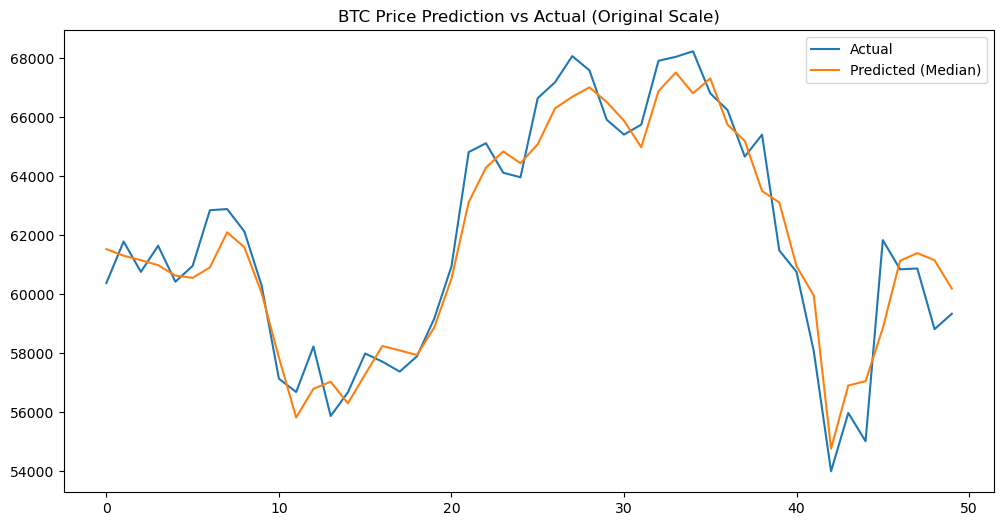

In [72]:
# Plot predictions vs actuals
plt.figure(figsize=(12, 6))
plt.plot(val_actuals_unscaled[-50:], label="Actual")
plt.plot(val_predictions_unscaled[-50:], label="Predicted (Median)")
plt.legend()
plt.title("BTC Price Prediction vs Actual (Original Scale)")
plt.show()

In [107]:
# load the best model according to the validation loss
# (given that we use early stopping, this is not necessarily the last epoch)
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

C:\Users\Sathmika\anaconda3\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
C:\Users\Sathmika\anaconda3\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


In [109]:
# raw predictions are a dictionary from which all kind of information including quantiles can be extracted
raw_predictions = best_tft.predict(val_dataloader, mode="raw", return_x=True)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\Sathmika\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:419: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.


In [111]:
# compute the mean absolute error on validation set
actuals = torch.cat([y[0] for _, y in iter(val_dataloader)])
val_prediction_results = best_tft.predict(val_dataloader)
print(f"Validation MAE: {(actuals - val_prediction_results.cpu().numpy()).abs().mean()}")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\Sathmika\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:419: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.


Validation MAE: 0.013263250701129436


In [113]:
import numpy as np
from sklearn.metrics import r2_score

# Convert tensors to NumPy
actuals_np = actuals.numpy()
predictions_np = val_prediction_results.cpu().numpy()

# Compute metrics
mae = np.mean(np.abs(actuals_np - predictions_np))
mse = np.mean((actuals_np - predictions_np) ** 2)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((actuals_np - predictions_np) / actuals_np)) * 100
smape = 100 * np.mean(2 * np.abs(actuals_np - predictions_np) / (np.abs(actuals_np) + np.abs(predictions_np)))
r2 = r2_score(actuals_np, predictions_np)

# Print results
print(f"Validation MAE: {mae}")
print(f"Validation MSE: {mse}")
print(f"Validation RMSE: {rmse}")
print(f"Validation MAPE: {mape}%")
print(f"Validation SMAPE: {smape}%")
print(f"Validation R²: {r2}")

Validation MAE: 0.013263248838484287
Validation MSE: 0.0002839456719812006
Validation RMSE: 0.016850687563419342
Validation MAPE: 1.597469113767147%
Validation SMAPE: 1.5788611024618149%
Validation R²: 0.8985079141815168


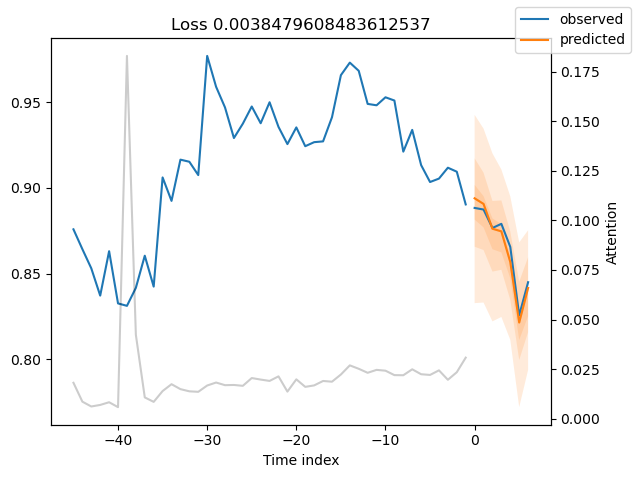

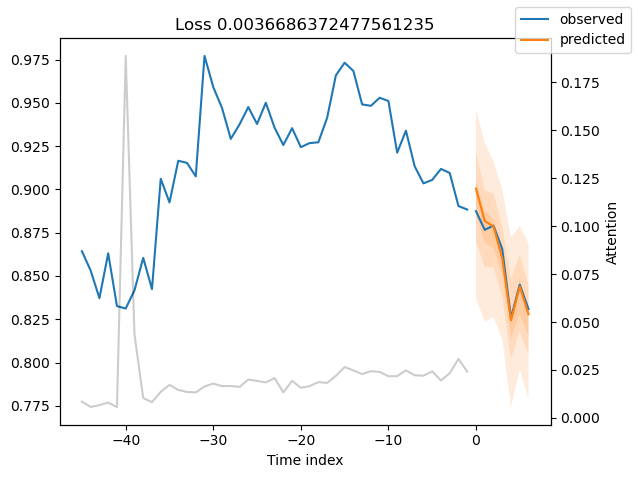

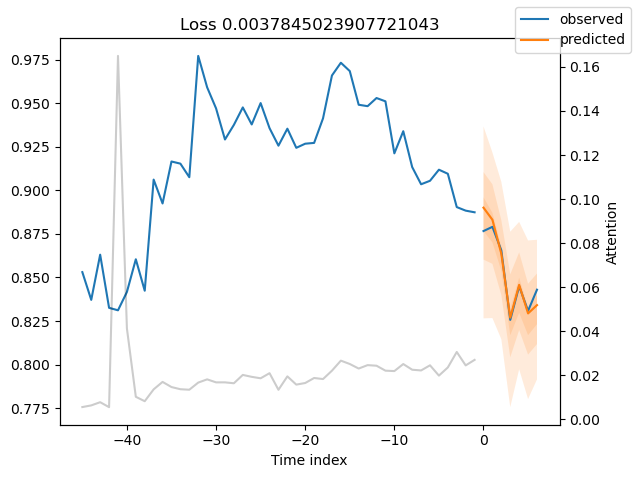

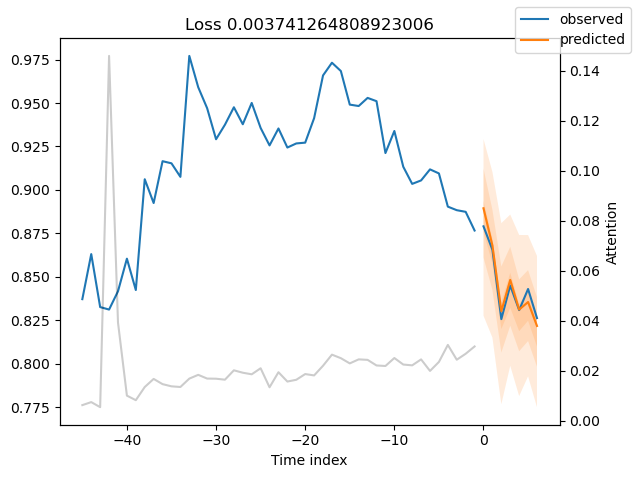

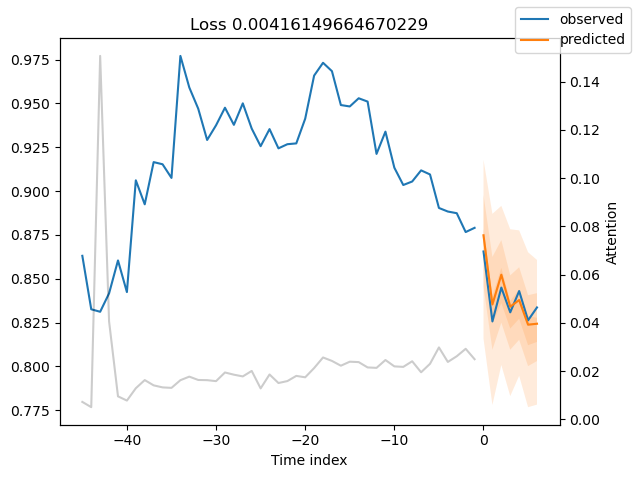

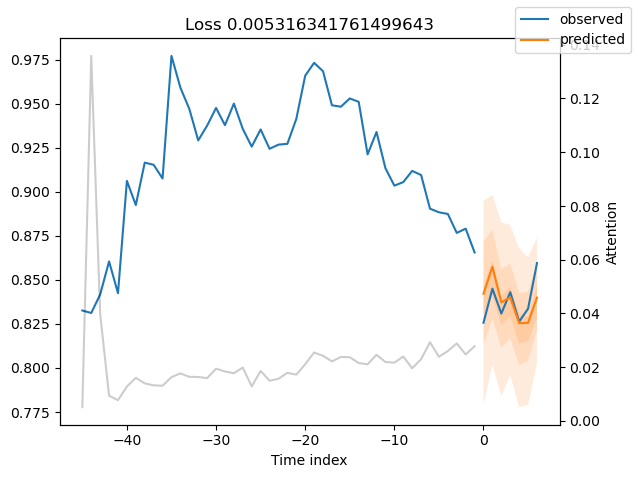

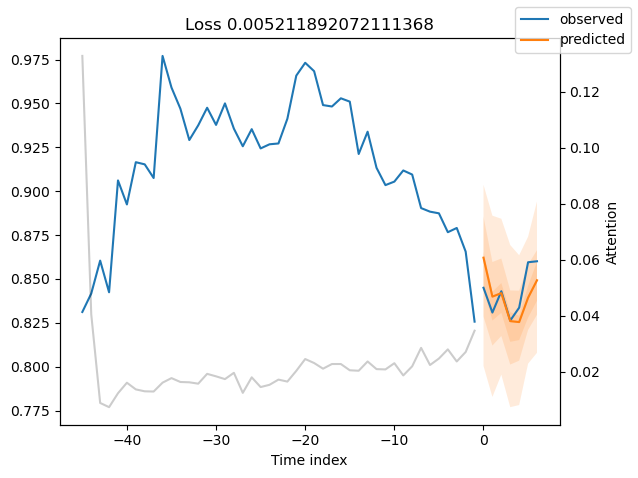

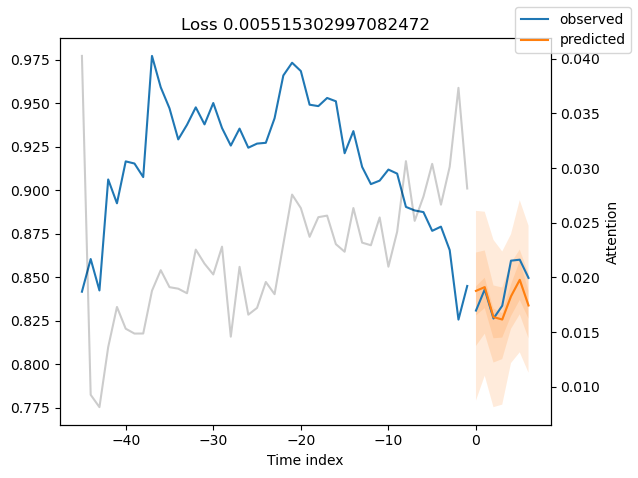

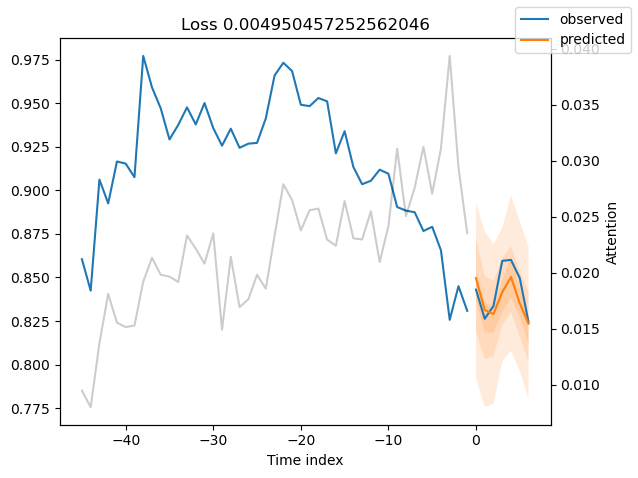

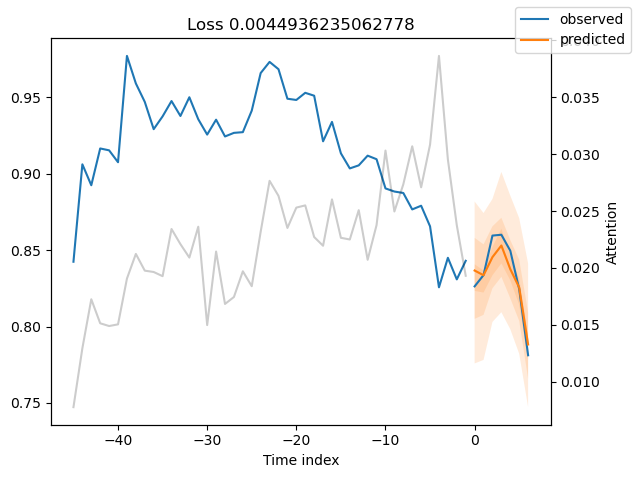

In [115]:
# Access the predictions from the named tuple
predictions_tensor = raw_predictions.output.prediction

# Get the number of available predictions (first dimension of the tensor)
num_predictions = predictions_tensor.size(0)

# Adjust loop to avoid out-of-bounds error
for idx in range(min(10, num_predictions)):  # Only iterate over available predictions
    best_tft.plot_prediction(raw_predictions.x, raw_predictions.output, idx=idx, add_loss_to_title=True)

## Load the Model 